# Training Neural Network - Deep Learning and Neural Networks with Python and Pytorch p.4

## Training our Neural Network
In the previous tutorial, we created the code for our neural network. In this deep learning with Python and Pytorch tutorial, we'll be actually training this neural network by learning how to iterate over our data, pass to the model, calculate loss from the result, and then do backpropagation to slowly fit our model to the data.

Code up to this point:

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))


trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


Luckily for us, the "data" that we're using from Pytorch is actually nice fancy object that is making life easy for us at the moment. It's already in pretty batches and we just need to iterate over it. Next, we want to calculate loss and specify our optimizer:

In [3]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

#### side note from *Andy*
Other Pytorch loss functions can be found at [Pytorch.nn](https://pytorch.org/docs/stable/nn.html#loss-functions)

Other Pytorch optimizers can be found at [Class Optimizer](https://pytorch.org/cppdocs/api/classtorch_1_1optim_1_1_optimizer.html)

ur loss_function is what calculates "how far off" our classifications are from reality. As humans, we tend to think of things in terms of either right, or wrong. With a neural network, and arguably humans too, our accuracy is actually some sort of scaling score.

For example, you might be highly confident that something is the case, but you are wrong. Compare this to a time when you really aren't certain either way, but maybe think something, but are wrong. In these cases, the degree to which you're wrong doesn't matter in terms of the choice necessarily, but in terms of you learning, it does.

In terms of a machine learning by tweaking lots of little parameters to slowly get closer and closer to fitting, it definitely matters how wrong things are.

For this, we use loss, which is a measurement of how far off the neural network is from the targeted output. There are a few types of loss calculations. A popular one is mean squared error, but we're trying to use these scalar-valued classes.

In general, you're going to have two types of classes. One will just be a scalar value, the other is what's called a one_hot array/vector.

In our case, a zero might be classified as:

0 or [1, 0, 0, 0, 0, 0, 0 ,0 ,0 ,0]

[1, 0, 0, 0, 0, 0, 0 ,0 ,0 ,0] is a one_hot array where quite literally one element only is a 1 and the rest are zero. The index that is hot is the classification.

A one_hot vector for a a 3 would be:

[0, 0, 0, 1, 0, 0, 0 ,0 ,0 ,0]

I tend to use one_hot, but this data is specifying a scalar class, so 0, or 1, or 2...and so on.

Depending on what your targets look like, you will need a specific loss.

For one_hot vectors, I tend to use mean squared error.

For these scalar classifications, I use cross entropy.

Next, we have our optimizer. This is the thing that adjusts our model's adjustable parameters like the weights, to slowly, over time, fit our data. I am going to have us using Adam, which is Adaptive Momentum. This is the standard go-to optimizer usually. There's a new one called rectified adam that is gaining steam. I haven't had the chance yet to make use of that in any project, and I do not think it's available as just an importable function in Pytorch yet, but keep your eyes peeled for it! For now, Adam will do just fine I'm sure. The other thing here is lr, which is the learning rate. A good number to start with here is 0.001 or 1e-3. The learning rate dictates the magnitude of changes that the optimizer can make at a time. Thus, the larger the LR, the quicker the model can learn, but also you might find that the steps you allow the optimizer to make are actually too big and the optimizer gets stuck bouncing around rather than improving. Too small, and the model can take much longer to learn as well as also possibly getting stuck.

Imagine the learning rate as the "size of steps" that the optimizer can take as it searches for the bottom of a mountain, where the path to the bottom isn't necessarily a simple straight path down. Here's some lovely imagery to help explain learning rate:
(learning-rate-too-high-too-low)[https://pythonprogramming.net/static/images/machine-learning/learning-rate-too-high-too-low.png]

The black line is the "path" to the bottom of the optimization curve. When it comes to optimizing, sometimes you have to get worse in order to actually get beyond some local optimum. The optimizer doesn't know what the absolute best spot could be, it just takes steps to see if it can find it. Thus, as you can see in the image, if the steps are too big, it will never get to the lower points. If the steps are too small (learning rate too small), it can get stuck as well long before it reaches a bottom. The goal is for something more like:(learning-rate-just-right)[https://pythonprogramming.net/static/images/machine-learning/learning-rate-just-right.png]

For simpler tasks, a learning rate of 0.001 usually is more than fine. For more complex tasks, you will see a learning rate with what's called a decay. Basically you start the learning rate at something like 0.001, or 0.01...etc, and then over time, that learning rate gets smaller and smaller. The idea being you can initially train fast, and slowly take smaller steps, hopefully getthing the best of both worlds:(decaying-lr)[https://pythonprogramming.net/static/images/machine-learning/decaying-lr.png]

More on learning rates and decay later. For now, 0.001 will work just fine, and you just need to think of learning rate as what it sounds like: How quickly should we try to get this optimizer to optimize things.

Now we can iterate over our data. In general, you will make more than just 1 pass through your entire training dataset.

Each full pass through your dataset is referred to as an epoch. In general, you will probably have somewhere between 3 and 10 epochs, but there's no hard rule here.

Too few epochs, and your model wont learn everything it could have.

Too many epochs and your model will over fit to your in-sample data (basically memorize the in-sample data, and perform poorly on out of sample data).

Let's go with 3 epochs for now. So we will loop over epochs, and each epoch will loop over our data. Something like:

In [4]:
#running this on a regular CPU
for epoch in range(3): # 3 full passes over the data
    for data in trainset:  # `data` is a batch of data
        X, y = data  # X is the batch of features, y is the batch of targets.
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(X.view(-1,784))  # pass in the reshaped batch (recall they are 28x28 atm)
        loss = F.nll_loss(output, y)  # calc and grab the loss value
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    print(loss)  # print loss. We hope loss (a measure of wrong-ness) declines! 

tensor(0.6431, grad_fn=<NllLossBackward>)
tensor(0.0432, grad_fn=<NllLossBackward>)
tensor(0.0061, grad_fn=<NllLossBackward>)


Every line here is commented, but the concept of gradients might not be clear. Once we pass data through our neural network, getting an output, we can compare that output to the desired output. With this, we can compute the gradients for each parameter, which our optimizer (Adam, SGD...etc) uses as information for updating weights.

This is why it's important to do a net.zero_grad() for every step, otherwise these gradients will add up for every pass, and then we'll be re-optimizing for previous gradients that we already optimized for. There could be times when you intend to have the gradients sum per pass, like maybe you have a batch of 10, but you want to optimize per 50 or something. I don't think people really do that, but the idea of Pytorch is to let you do whatever you want.

So, for each epoch, and for each batch in our dataset, what do we do?

Grab the features (X) and labels (y) from current batch
Zero the gradients (net.zero_grad)
Pass the data through the network
Calculate the loss
Adjust weights in the network with the hopes of decreasing loss
As we iterate, we get loss, which is an important metric, but we care about accuracy. So, how did we do? To test this, all we need to do is iterate over our test set, measuring for correctness by comparing output to target values.

In [5]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1,784))
        #print(output)
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.966


Yeah, I would say we did alright there.

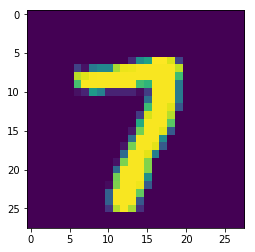

In [6]:
import matplotlib.pyplot as plt

plt.imshow(X[0].view(28,28))
plt.show()

In [7]:
print(torch.argmax(net(X[0].view(-1,784))[0]))

tensor(7)


The above might be slightly confusing. I'll break it down.

In [8]:
a_featureset = X[0]
reshaped_for_network = a_featureset.view(-1,784) # 784 b/c 28*28 image resolution.
output = net(reshaped_for_network) #output will be a list of network predictions.
first_pred = output[0]
print(first_pred)

tensor([-1.6936e+01, -7.4109e+00, -7.4424e+00, -4.0751e+00, -1.5709e+01,
        -1.3095e+01, -2.6675e+01, -1.8489e-02, -1.0788e+01, -9.0661e+00],
       grad_fn=<SelectBackward>)


Which index value is the greatest? We use argmax to find this:

In [9]:
biggest_index = torch.argmax(first_pred)
print(biggest_index)

tensor(7)


There's so much more we could do here with this example, but I think it's best we move on.

More things to consider: Tracking/graphing loss and accuracy over time, comparing in and out of sample accuracy, maybe hand-drawing our own example to see if it works...etc.

As fun and easy as it is to use a pre-made dataset, one of the first things you really want to do once you learn deep learning is actually do something you're interested in, which often means your own dataset that isn't prepared for us like this one was.

In the coming tutorials, we're going to discuss the convolutional neural network and classify images of dogs and cats, starting from the raw images, as well as covering some of the other topics like tracking training over time.

#### side note from *Andy*
If you liked this series there are 4 more modules talking about CNN.  Let me know if you would like this in a jupyter notebook, and I can convert it over for you.
Check out [https://pythonprogramming.net](https://pythonprogramming.net)

If you would like to see how Jeremy approached this, check it out.
However, be careful as they move to CNN vs ANN.
[WHAT IS TORCH.NN REALLY?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)
